In [2]:
import sys
sys.path.append("../lib/")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler

from sklearn.decomposition import PCA, NMF
from sklearn.cluster import FeatureAgglomeration
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, l1_min_c, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectFromModel

In [3]:
from raman_lib.preprocessing import SavGolFilter, RangeLimiter, BaselineCorrector, PeakPicker
from raman_lib.misc import load_data
from raman_lib.crossvalidation import CrossValidator

In [20]:
data = load_data("../results/L_540_2022_C_E/L_540_2022_C_E_preprocessed.csv")
data

,label,file,450.0,450.5,451.0,451.5,452.0,452.5,453.0,453.5,...,1665.5,1666.0,1666.5,1667.0,1667.5,1668.0,1668.5,1669.0,1669.5,1670.0
0,Control,/home/daniel/Raman_Daten/L_540_2022/Control/C2.49,0.013808,0.013834,0.013726,0.013511,0.013219,0.012878,0.012517,0.012165,...,0.003212,0.003262,0.003298,0.003307,0.003310,0.003310,0.003311,0.003318,0.003333,0.003361
1,Control,/home/daniel/Raman_Daten/L_540_2022/Control/C2.2,0.004200,0.004252,0.004331,0.004429,0.004540,0.004659,0.004778,0.004891,...,0.003402,0.003486,0.003579,0.003692,0.003813,0.003940,0.004071,0.004205,0.004338,0.004470
2,Control,/home/daniel/Raman_Daten/L_540_2022/Control/C2.28,0.011667,0.011785,0.011890,0.011997,0.012123,0.012283,0.012494,0.012770,...,0.006201,0.006110,0.005997,0.005852,0.005709,0.005581,0.005479,0.005414,0.005397,0.005440
3,Control,/home/daniel/Raman_Daten/L_540_2022/Control/C2.41,0.008482,0.008046,0.007631,0.007236,0.006857,0.006494,0.006143,0.005802,...,0.016057,0.015064,0.014107,0.013211,0.012364,0.011569,0.010829,0.010148,0.009530,0.008977
4,Control,/home/daniel/Raman_Daten/L_540_2022/Control/C3.75,0.005659,0.005459,0.005178,0.004838,0.004462,0.004074,0.003697,0.003353,...,0.003159,0.003180,0.003194,0.003231,0.003261,0.003277,0.003273,0.003243,0.003180,0.003079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Etoposide,/home/daniel/Raman_Daten/L_540_2022/Etoposide/...,0.008204,0.008586,0.008825,0.008940,0.008949,0.008871,0.008724,0.008526,...,0.004489,0.004879,0.005158,0.005329,0.005394,0.005331,0.005116,0.004727,0.004141,0.003335
596,Etoposide,/home/daniel/Raman_Daten/L_540_2022/Etoposide/...,0.024420,0.021128,0.018777,0.017235,0.016367,0.016042,0.016126,0.016485,...,0.004667,0.004245,0.004055,0.003993,0.004035,0.004161,0.004355,0.004597,0.004870,0.005156
597,Etoposide,/home/daniel/Raman_Daten/L_540_2022/Etoposide/...,0.013597,0.012507,0.011994,0.011979,0.012382,0.013123,0.014123,0.015302,...,0.004730,0.004489,0.004291,0.004166,0.004125,0.004191,0.004383,0.004724,0.005235,0.005936
598,Etoposide,/home/daniel/Raman_Daten/L_540_2022/Etoposide/...,0.021917,0.018384,0.015732,0.013827,0.012536,0.011729,0.011273,0.011034,...,0.007978,0.007258,0.006495,0.005806,0.005193,0.004715,0.004430,0.004400,0.004682,0.005336


In [21]:
X = data.drop(columns=["label", "file"], errors="ignore")
wns = np.asarray(X.columns.astype(float))
X = np.asarray(X)
y = np.asarray(data.label)
y, y_key = pd.factorize(y)

In [7]:
X_orig = X.copy()
X = BaselineCorrector().fit_transform(X)

rl = RangeLimiter(lim=(450, 1670), reference=wns)
X = rl.fit_transform(X)
wns = wns[rl.lim_[0]:rl.lim_[1]]

X = SavGolFilter().fit_transform(X)

X = Normalizer().fit_transform(X)

In [156]:

clf = LGBMClassifier(random_state=2434, colsample_bytree=0.2, max_bin=10, max_depth=5)

param_grid = {
   "learning_rate": np.linspace(0.05, 0.5, 10)
}


In [157]:

cv = CrossValidator(clf,
                    param_grid,
                    n_trials=3,
                    n_jobs=10,
                    scoring="accuracy",
                    feature_names=wns).fit(X, y)

  0%|          | 0/3 [00:00<?, ?it/s]

In [158]:
pd.DataFrame(cv.ct_results_)

,train_score,test_score,fit_time,predict_time,p_value
0,1.000000,0.905000,8.150252,0.001342,5.532965e-46
1,1.000000,0.916667,8.133372,0.000985,4.542619e-49
2,0.999583,0.906667,8.159809,0.001003,1.364623e-45


In [160]:
pd.DataFrame(cv.cv_results_)

,param_learning_rate,param_reg_lambda,train_score_0,test_score_0,train_score_1,test_score_1,train_score_2,test_score_2
0,0.05,0.01,1.000000,0.896667,1.000000,0.911667,1.000000,0.905000
1,0.05,0.10,1.000000,0.893333,1.000000,0.913333,1.000000,0.905000
2,0.05,1.00,0.999583,0.898333,1.000000,0.901667,1.000000,0.908333
3,0.05,10.00,0.983750,0.895000,0.984583,0.908333,0.983333,0.898333
4,0.05,100.00,0.919583,0.866667,0.917083,0.861667,0.921250,0.880000
5,0.10,0.01,1.000000,0.903333,1.000000,0.915000,1.000000,0.906667
6,0.10,0.10,1.000000,0.898333,1.000000,0.910000,1.000000,0.913333
7,0.10,1.00,1.000000,0.898333,1.000000,0.910000,1.000000,0.920000
8,0.10,10.00,1.000000,0.905000,1.000000,0.913333,0.999583,0.893333
9,0.10,100.00,0.943750,0.880000,0.944167,0.885000,0.945000,0.883333


In [161]:
cv.param_results_

defaultdict(list,
            {'learning_rate': [0.3, 0.15000000000000002, 0.1],
             'reg_lambda': [0.1, 0.01, 1.0]})

In [44]:
shap.dependence_plot("rank(1)", cv.shap_results_.values, cv.shap_results_.data, feature_names=cv.shap_results_.feature_names)

AttributeError: 'CrossValidator' object has no attribute 'shap_results_'

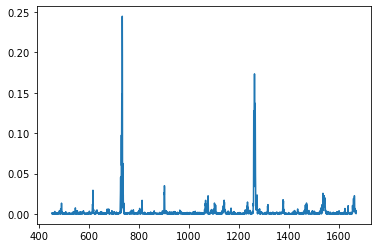

In [100]:
plt.plot(wns, np.mean(np.absolute(cv.shap_results_.values), axis=0))

In [ ]:
# %matplotlib widget
# from raman_lib.visualization import plot_spectra_peaks

# plot_spectra_peaks(wns, X_orig[y_false], labels=np.asarray(data.file)[y_false])

ValueError: invalid literal for int() with base 10: '1.0'